```
Jump entropy signal -> 
    - remove telegraaf
    - window 28 (4 weeks)

DTW distances ->

UMAP projection ->
    - fixed random state for reproducibility

Agglomerative Clustering ->
    Export parameter search plots

Per-cluster DBA ->
    - switch to dtw_barycenter_averaging
```

In [27]:
import os
import sys
import pickle

import pandas as pd
import numpy as np
import ndjson

import matplotlib.pyplot as plt
import seaborn as sns

import umap
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.barycenters import dtw_barycenter_averaging, softdtw_barycenter
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import cdist_dtw
from tslearn.utils import to_time_series_dataset
from sklearn.cluster import AgglomerativeClustering

# plot settigns
plt.rcParams.update({"text.usetex": False,
                    "font.family": "Times New Roman",
                    "font.serif": "serif",
                    "mathtext.fontset": "cm",
                    "axes.unicode_minus": False,
                    "axes.labelsize": 9,
                    "xtick.labelsize": 9,
                    "ytick.labelsize": 9,
                    "legend.fontsize": 9,
                    "axes.linewidth": 1
                    })

In [28]:
# local scripts in src/
sys.path.append(os.path.join('..', 'src'))

from data_loader import extract_timeseries, ts_to_frame
from dtw_comparisons import calculate_pairwise_dtw
from dimensionality import fit_projection
from clusters import grid_search_clustering, plot_elbow, plot_dendrogram

<br>

# Processing signal

In [29]:
# Load signal, curb ts length
dataset_path = os.path.join('output', 'event_flow_90.json')

with open(dataset_path) as fin:
    event_flow_90 = ndjson.load(fin)

ts30 = extract_timeseries(
    event_flow_90, window=28, remove_empty=True, undesired_newspapers=['all'])

df_ts30 = ts_to_frame(ts30)

In [30]:
# rescale
ts30_dict = {k: v for node in ts30 for k, v in node.items()}
event_keys = list(set(df_ts30['newspaper_event']))

signals = [ts30_dict[node] for node in event_keys]

ts_signals = to_time_series_dataset(signals)
ts_signals = TimeSeriesScalerMeanVariance().fit_transform(ts_signals)

In [31]:
# Calculate pairwise DTW distance between time series
dist_mat = cdist_dtw(ts_signals)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


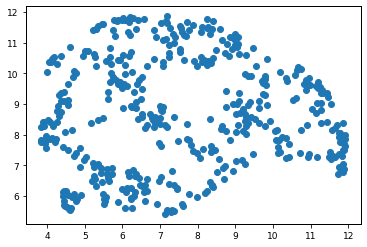

In [6]:
# Project to 2D with UMAP

X = umap.UMAP(random_state=42, n_neighbors=20).fit_transform(dist_mat)

plt.scatter(X[:, 0], X[:, 1])

In [7]:
# setup outdirs
analysis_dir = os.path.join('output', 'clusters')

outdir = os.path.join(analysis_dir, 'grid_search')
outdir_dba = os.path.join(analysis_dir, 'dba')

for path in [outdir, outdir_dba]:
    if not os.path.exists(path):
        os.makedirs(path)
    else:
        print(f'path exists: {path}')

path exists: output/clusters/grid_search
path exists: output/clusters/dba


<br>

# Grid search

In [8]:
# Parameters for grid search
# Split into two sets, because they are mutually exclusive
params_a = {
    'n_clusters': [2, 3, 4, 5, 6, 7, 8],
    'affinity': ['euclidean'],
    'compute_full_tree': [False],
    'linkage': ['ward', 'complete', 'average'],
    'distance_threshold': [None]
}

params_b = {
    'n_clusters': [2, 3, 4, 5, 6, 7, 8],
    'affinity': ['euclidean', 'l1', 'l2', 'manhattan', 'cosine'],
    'compute_full_tree': [False],
    'linkage': ['complete', 'average'],
    'distance_threshold': [None]
}

### Parameter space A

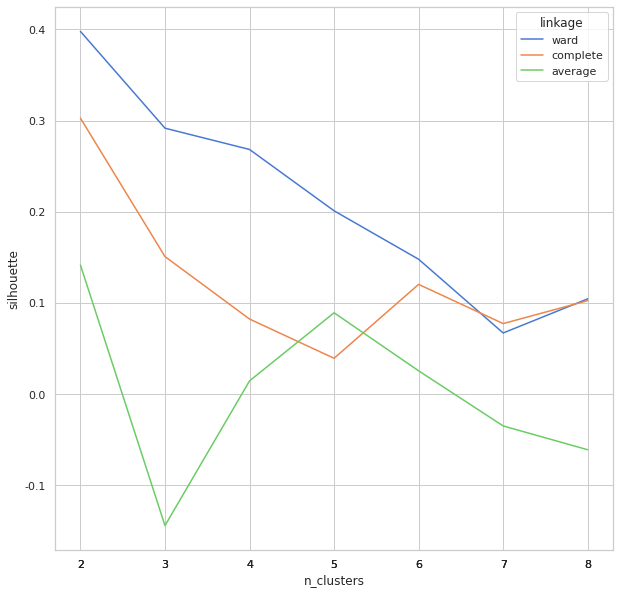

In [9]:
# Grid search through params_a
grid_a = grid_search_clustering(
    X=dist_mat,
    parameters=params_a,
    algorithm=AgglomerativeClustering,
    use_silhouette=True,
)

grid_a_elbow, grid_a_df = plot_elbow(
    grid_a,
    metric='silhouette',
    prim_param='n_clusters',
    sec_param='linkage',
    get_df=True
)

grid_a_elbow.get_figure().savefig(os.path.join(outdir, 'grid_a_elbow.png'))

In [10]:
# models in params_a
(grid_a_df
    .sort_values('silhouette', ascending=False)
)

,silhouette,train_time,params,affinity,compute_full_tree,distance_threshold,linkage,n_clusters
0,0.397897,0.033090,"{'affinity': 'euclidean', 'compute_full_tree':...",euclidean,False,None,ward,2
7,0.302732,0.104712,"{'affinity': 'euclidean', 'compute_full_tree':...",euclidean,False,None,complete,2
1,0.291743,0.050179,"{'affinity': 'euclidean', 'compute_full_tree':...",euclidean,False,None,ward,3
2,0.268389,0.097850,"{'affinity': 'euclidean', 'compute_full_tree':...",euclidean,False,None,ward,4
3,0.201094,0.101410,"{'affinity': 'euclidean', 'compute_full_tree':...",euclidean,False,None,ward,5
8,0.150879,0.102177,"{'affinity': 'euclidean', 'compute_full_tree':...",euclidean,False,None,complete,3
4,0.147934,0.100631,"{'affinity': 'euclidean', 'compute_full_tree':...",euclidean,False,None,ward,6
14,0.141606,0.097017,"{'affinity': 'euclidean', 'compute_full_tree':...",euclidean,False,None,average,2
11,0.120380,0.101628,"{'affinity': 'euclidean', 'compute_full_tree':...",euclidean,False,None,complete,6
6,0.104524,0.097900,"{'affinity': 'euclidean', 'compute_full_tree':...",euclidean,False,None,ward,8


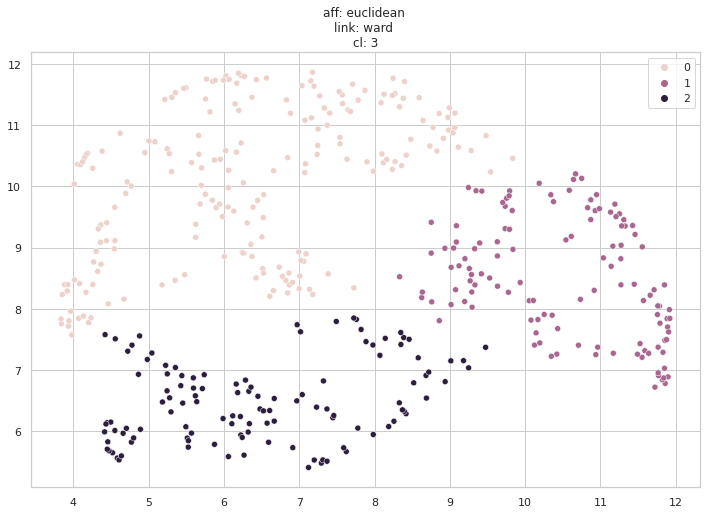

In [11]:
# best model from params_a
# best model from grid A
mdl_a = AgglomerativeClustering(
    affinity='euclidean',
    linkage='ward',
    n_clusters=3
)

mdl_a.fit(X)

plt.figure(figsize=(12, 8))
fig_best_a = sns.scatterplot(
    x=X[:, 0],
    y=X[:, 1],
    hue=mdl_a.labels_)

plt.title(f'aff: {mdl_a.affinity} \nlink: {mdl_a.linkage} \ncl: {mdl_a.n_clusters}')

fig_best_a.get_figure().savefig(
    os.path.join(outdir, 'best_a.png')
    )

### Parameter space B

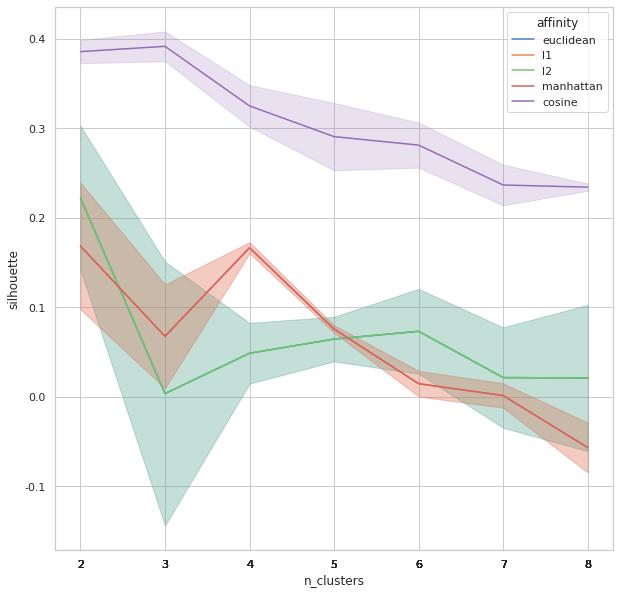

In [12]:
# Grid search through params_b
grid_b = grid_search_clustering(
    X=dist_mat,
    parameters=params_b,
    algorithm=AgglomerativeClustering,
    use_silhouette=True
)

grid_b_elbow, grid_b_df = plot_elbow(
    grid_b,
    metric='silhouette',
    prim_param='n_clusters',
    sec_param='affinity',
    get_df=True
)

grid_b_elbow.get_figure().savefig(os.path.join(outdir, 'grid_b_elbow.png'))

In [13]:
(grid_b_df
    .query('affinity == "cosine"')
    .sort_values('silhouette', ascending=False)
)

,silhouette,train_time,params,affinity,compute_full_tree,distance_threshold,linkage,n_clusters
57,0.408202,0.112536,"{'affinity': 'cosine', 'compute_full_tree': Fa...",cosine,False,None,complete,3
56,0.398539,0.101176,"{'affinity': 'cosine', 'compute_full_tree': Fa...",cosine,False,None,complete,2
64,0.374820,0.105690,"{'affinity': 'cosine', 'compute_full_tree': Fa...",cosine,False,None,average,3
63,0.372647,0.105587,"{'affinity': 'cosine', 'compute_full_tree': Fa...",cosine,False,None,average,2
65,0.348185,0.173276,"{'affinity': 'cosine', 'compute_full_tree': Fa...",cosine,False,None,average,4
66,0.328184,0.105718,"{'affinity': 'cosine', 'compute_full_tree': Fa...",cosine,False,None,average,5
67,0.306344,0.104649,"{'affinity': 'cosine', 'compute_full_tree': Fa...",cosine,False,None,average,6
58,0.301651,0.107554,"{'affinity': 'cosine', 'compute_full_tree': Fa...",cosine,False,None,complete,4
68,0.259258,0.102422,"{'affinity': 'cosine', 'compute_full_tree': Fa...",cosine,False,None,average,7
60,0.255884,0.102484,"{'affinity': 'cosine', 'compute_full_tree': Fa...",cosine,False,None,complete,6


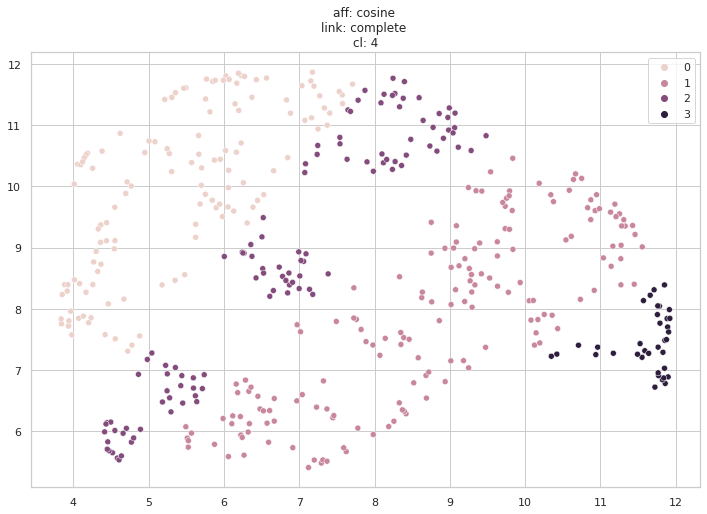

In [14]:
# Best model from params_b
mdl_b = AgglomerativeClustering(
    affinity='cosine',
    linkage='complete',
    n_clusters=4
)

mdl_b.fit(X)

plt.figure(figsize=(12, 8))
fig_best_b = sns.scatterplot(
    x=X[:, 0],
    y=X[:, 1],
    hue=mdl_b.labels_)

plt.title(f'aff: {mdl_b.affinity} \nlink: {mdl_b.linkage} \ncl: {mdl_b.n_clusters}')

fig_best_b.get_figure().savefig(
    os.path.join(outdir, 'best_b.png')
    )

### Fit a full tree

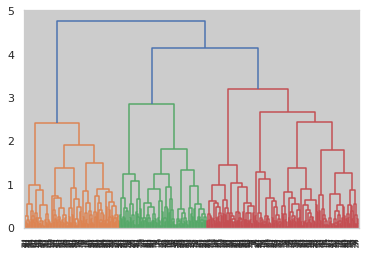

In [15]:
# See whole dendogram for validation
# Using the best model from both params_a and params_b
mdl_c = AgglomerativeClustering(
    affinity='euclidean',
    linkage='average',
    distance_threshold=0,
    n_clusters=None
)

mdl_c.fit(X)

plot_dendrogram(mdl_c)

## Best model

Text(0.5, 1.0, 'aff: euclidean \nlink: average \ncl: 5')

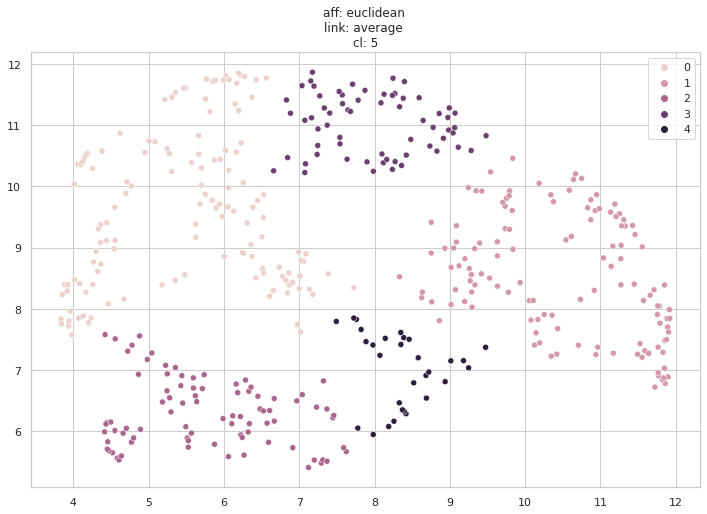

In [16]:
n_cl = 5

mdl_d = AgglomerativeClustering(
    affinity='euclidean',
    linkage='average',
    n_clusters=n_cl
)

mdl_d.fit(X)

plt.figure(figsize=(12, 8))
fig_best_d = sns.scatterplot(
    x=X[:, 0],
    y=X[:, 1],
    hue=mdl_d.labels_)

plt.title(f'aff: {mdl_d.affinity} \nlink: {mdl_d.linkage} \ncl: {mdl_d.n_clusters}')

<br>

# Archetypical time series

In [17]:
df_res = pd.DataFrame(X, columns=['X', 'Y'])
df_res['node'] = event_keys
df_res['cluster'] = mdl_d.labels_

ts30_scaled = []
for event, signal in zip(event_keys, ts_signals):
    signal_ = [i[0] for i in signal.tolist()]
    ts30_scaled.append({event: signal_})

ts30_scaled_dict = {k: v for node in ts30_scaled for k, v in node.items()}

In [18]:
def get_dba_per_cluster(df, ts_dict, norm=False):
    res = []
    for cl_name, cl_cols in df.groupby('cluster'):
        cluster_signals = []
        for node in cl_cols['node']:
            ts = ts_dict[node]
            cluster_signals.append(ts)
        
        if norm:
            cluster_signals = to_time_series_dataset(cluster_signals)
            cluster_signals = TimeSeriesScalerMeanVariance().fit_transform(cluster_signals)

        cluster_dba = dtw_barycenter_averaging(
            cluster_signals, max_iter=50, tol=1e-4)
        
        res.append({
            'cluster': cl_name,
            'dba': cluster_dba,
            'cluster_signals': cluster_signals
        })
    
    return res

res_raw = get_dba_per_cluster(df_res, ts30_scaled_dict, norm=False)

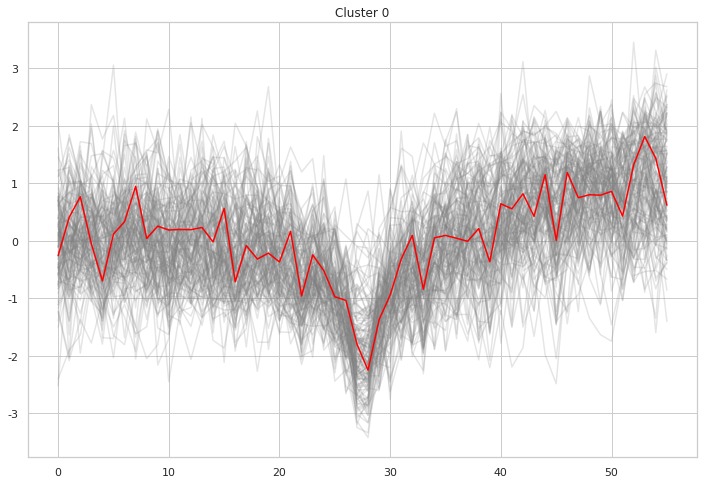

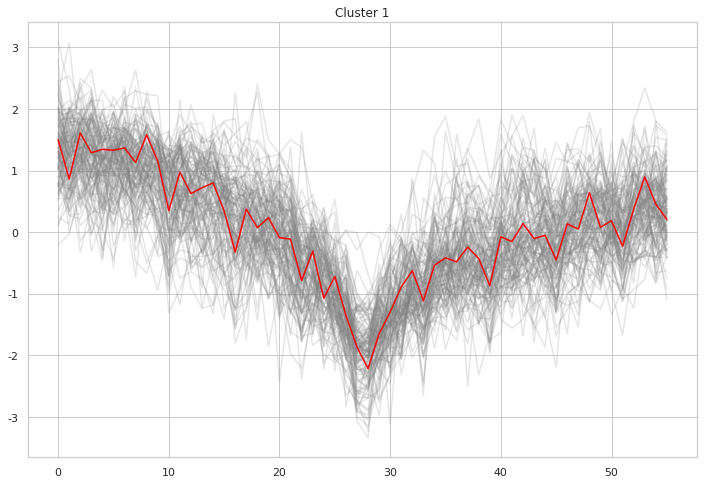

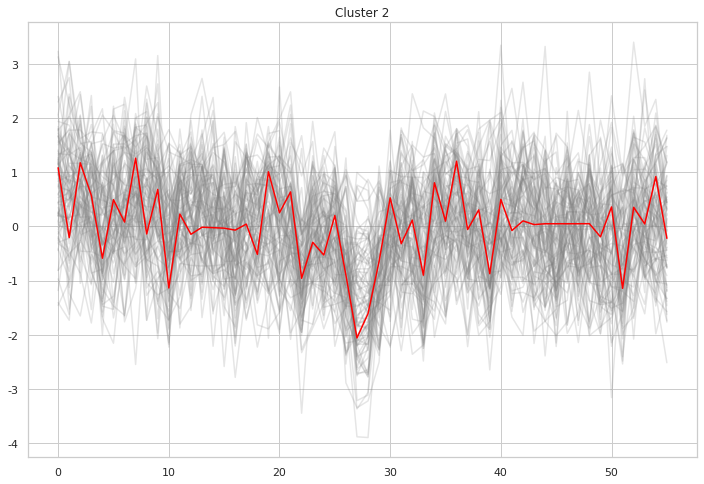

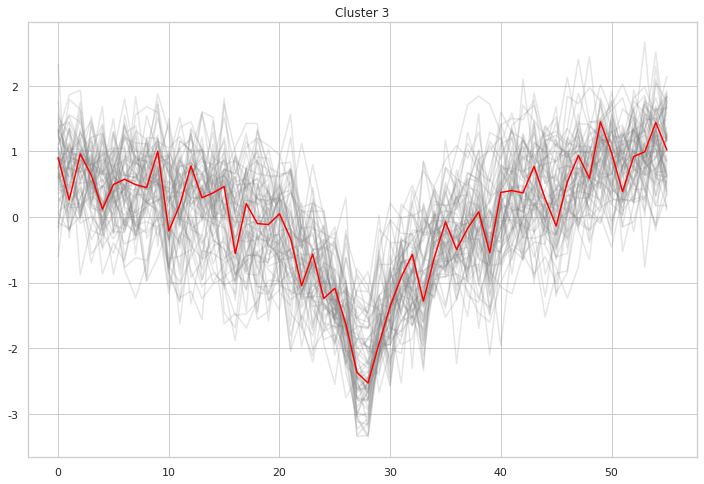

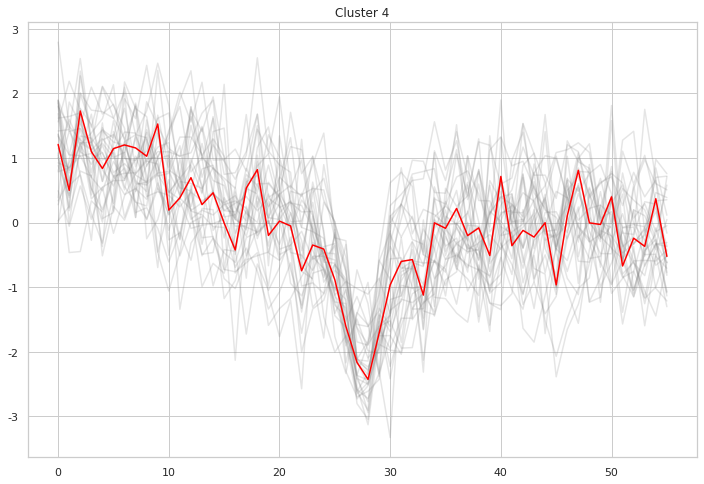

In [19]:
def plot_cluster(results, cluster_id:int, outpath):

    plt.figure(figsize=(12, 8))
    for series in results[cluster_id]['cluster_signals']:
        plt.plot(series, alpha=0.2, color='grey')
    plt.plot(results[cluster_id]['dba'], color='red')

    cluster_label = results[cluster_id]['cluster']
    plt.title(f'Cluster {cluster_label}')
    if outpath:
        plt.savefig(outpath)
    else:
        plt.show()


for i in range(0, n_cl, 1):
    fname = os.path.join(outdir_dba, str(i))
    if not os.path.exists(fname):
        plot_cluster(res_raw, i, outpath=fname)
    else:
        print('warning: plot already exists!')

In [20]:
# # save output
# with open(os.path.join(outdir, 'X.pcl'), 'wb') as fout:
#     pickle.dump(X, fout)

# with open(os.path.join(outdir, 'model_full.pcl'), 'wb') as fout:
#     pickle.dump(mdl_c, fout)

# with open(os.path.join(outdir, 'model_best.pcl'), 'wb') as fout:
#     pickle.dump(mdl_d, fout)

# with open(os.path.join(outdir, 'signal_n_dba.pcl'), 'wb') as fout:
#     pickle.dump(res_raw, fout)

# Visualization

To get the dendrogram plot run:

```{shell}
cd event-flow/
python src/plot_clusters.py
```

The plot will be saved in `notebooks/output/clusters/{timestamp}_cluster_dendrogram.png`